In [35]:
import numpy as np
import networkx as nx
from dijkstar import Graph, find_path
import scipy.io
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.linalg import eigh

In [298]:
def distance(x,y):
    return np.linalg.norm(x - y)

def gaussians(k, d, n):
    centers = np.linspace(-5*k, 5*k, num = k)
    data = []
    for center in centers:
        mid = np.zeros(d)
        mid[0] = center
        data.append(np.random.multivariate_normal(mid, np.identity(d), int(n/k)))
    data2 = []
    for center in data:
        for point in center:
            data2.append(point)
    return np.array(data2)

def face(sub):
    mat = scipy.io.loadmat('data/face_data.mat')
    return mat['images'].T[:np.shape(mat['images'])[1]-1:sub]

def swiss_roll(sub):
    mat = scipy.io.loadmat('data/swiss_roll_data.mat')
    return mat['X_data'].T[:np.shape(mat['X_data'])[1]-1:sub]

def get_pairwise_distances(X):
    return squareform(pdist(X, 'euclidean'))
#     n = X.shape[0]
#     pairwise = np.full((n,n), np.inf)
#     for i in range(n):
#         for j in range(n):
#             pairwise[i,j] = distance(X[i], X[j])
#     return pairwise

def mds(D, k):
    n = D.shape[0]
    centering_matrix = np.identity(n) - (1/n * np.ones((n,n)))
    
    target_matrix = -0.5 * centering_matrix @ np.square(D) @ centering_matrix
    eigval, eigvec = np.linalg.eigh(target_matrix)
    
    # find k largest eigenvalues, get the eigenvectors
    V = eigvec[:,-k:]
    L = np.diag(np.sqrt(eigval[-k:]))
    embedding = V @ L
    
    return embedding

def isomap(X, k, epsilon):
    n = X.shape[0]
    # Form graph
    
    graph = Graph()
    for i in range(n):
        for j in range(i+1,n):
            if distance(X[i], X[j]) < epsilon:
                graph.add_edge(i,j,distance(X[i], X[j]))
                graph.add_edge(j,i,distance(X[i], X[j]))
    isomap_metric = np.zeros((n,n))
    for i in range(n):
        #print(i)
        for j in range(n):
#             print(find_path(graph, i, j)[3])
            isomap_metric[i,j] = find_path(graph, i, j)[3]
    
    
#     G = nx.Graph()
#     for i in range(n):
#         G.add_node(i, coord = X[i])
#     for i in range(n):
#         for j in range(i+1, n):
#             if distance(X[i], X[j]) < epsilon:
#                 G.add_edge(i,j, weight = distance(X[i], X[j]))
#     isomap_metric = np.zeros((n,n))
#     for i in range(n):
#         print(i)
#         for j in range(n):
#             isomap_metric[i,j] = nx.shortest_path_length(G,i,j, weight = 'weight', method = 'bellman-ford')

    #perform MDS
    embedding = mds(isomap_metric, k)
    
    return embedding

def lle(X, n_neighbors, k):
    weights = lle_first(X,n_neighbors)
    embedding = lle_second(weights, k)
    return embedding


# given X, k, return weights
def lle_first(X, n_neighbors):
    n = X.shape[0]
    D = get_pairwise_distances(X)
    W = np.zeros((n,n))
    for i in range(n):
        neigh_indices = np.argsort(D[i])[1:n_neighbors+1]
        w_i = np.ones(n_neighbors)
        C = np.zeros((n_neighbors,n_neighbors))
        #solve optimisation for neighbours
        for j1 in range(n_neighbors):
            for j2 in range(n_neighbors):
                C[j1,j2] = (X[i] - X[neigh_indices[j1]]).dot(((X[i] - X[neigh_indices[j2]])))
        w = np.linalg.solve(C, w_i)
        w = w / np.sum(w)
        for j in range(n_neighbors):
            W[i, neigh_indices[j]] = w[j]
    return W
        
def lle_second(W, k):
    #solve eigendecomposition for relevant matrix
    n = W.shape[0]
    M = (np.identity(n) - W).T @ (np.identity(n) - W)

    eigval, eigvec = np.linalg.eig(M)
    
    # find k smallest eigenvectors (throw out the zero eigenvector)
    indices = np.argsort(eigval)
    embedding = np.zeros((n,k))
    for i in range(k):
        embedding[:,i] = eigvec[:,indices[i+1]]
#     print(eigval)
#     print(eigvec[indices[0]])
#     print(M)
    return embedding
    
def laplacian_eigenmap(X, k, s=3):
    pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))
    S = np.exp(-pairwise_sq_dists / s**2)   #similarity matrix
    W = S

    D = np.diag(1/np.sqrt(np.sum(W, axis=1)))
    L = np.eye(W.shape[0])-np.dot(np.dot(D,W),D)  #laplacian matrix
#     D = np.diag(np.sum(W, axis=1))
#     L = D - W
#     L = np.dot(L, np.linalg.inv(D))
    e, v = eigh(L)                                #eigvectors, eigenvalues
    first_k_v = v[:, :k]                          #first eigenvalue
    low_dim_data = first_k_v
    return low_dim_data

def loss(original, embedded):
    return np.linalg.norm(get_pairwise_distances(original) - get_pairwise_distances(embedded)) / (original.shape[0])**2

In [36]:
np.random.seed(1600)

In [294]:
X = face(divide)
# face_embedding_mds = mds(get_pairwise_distances(X),dim)
# face_embedding_iso = isomap(X, dim, epsilon)
# face_embedding_lle = lle(X,n_neigh, dim)
# face_embedding_lap = laplacian_eigenmap(X, dim, s = sigma)

In [386]:
dim = 2
divide = 100
epsilon = 11
n_neigh = 50
sigma = 15

In [387]:
X = swiss_roll(divide)
#roll_embedding_mds = mds(get_pairwise_distances(X),dim)
# roll_embedding_iso = isomap(X, dim, epsilon)
roll_embedding_lle = lle(X,n_neigh,dim)

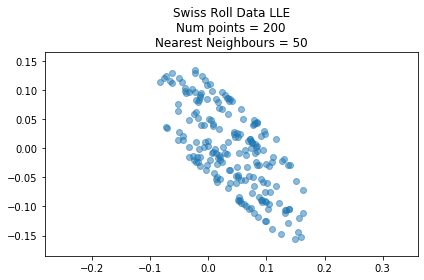

In [388]:
plt.figure()
plt.scatter(roll_embedding_lle[:,0], roll_embedding_lle[:,1], alpha=0.5)
title = "Swiss Roll Data LLE\nNum points = {}\nNearest Neighbours = {}".format(roll_embedding_lle.shape[0], n_neigh)
plt.title(title)
plt.tight_layout()
plt.axis('equal')
plt.savefig("fig/{}.png".format(title.replace("\n", "_").replace(" ", "_")), dpi = 400)
plt.show()

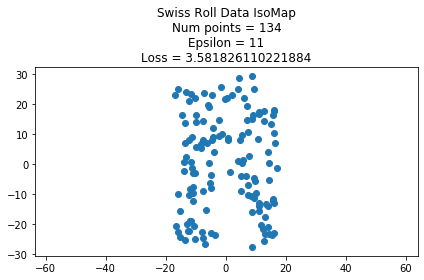

In [351]:
plt.figure()
plt.scatter(roll_embedding_iso[:,0], roll_embedding_iso[:,1])
title = "Swiss Roll Data IsoMap\nNum points = {}\nEpsilon = {}\nLoss = {}".format(roll_embedding_iso.shape[0], epsilon, loss(roll_embedding_iso, X)*100)
plt.title(title)
plt.tight_layout()
plt.axis('equal')
plt.savefig("fig/{}.png".format(title.replace("\n", "_").replace(" ", "_")), dpi = 400)
plt.show()

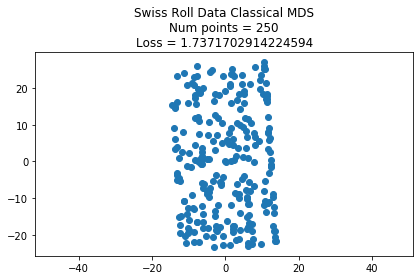

In [325]:
plt.figure()
plt.scatter(roll_embedding_mds[:,0], roll_embedding_mds[:,1])
title = "Swiss Roll Data Classical MDS\nNum points = {}\nLoss = {}".format(roll_embedding_mds.shape[0], loss(roll_embedding_mds, X)*100)
plt.title(title)
plt.tight_layout()
plt.axis('equal')
plt.savefig("fig/{}.png".format(title.replace("\n", "_").replace(" ", "_")), dpi = 400)
plt.show()

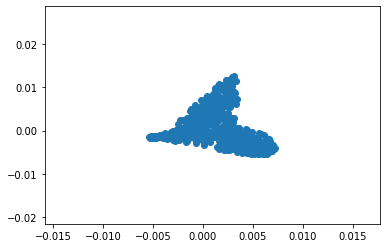

In [296]:
from sklearn.manifold import SpectralEmbedding
emb = SpectralEmbedding(n_components = 2, affinity = 'precomputed')
pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))
S = np.exp(-pairwise_sq_dists / 15**2) 
X_t = emb.fit_transform(S)
plt.figure()
plt.scatter(X_t[:,0], X_t[:,1])
plt.show()

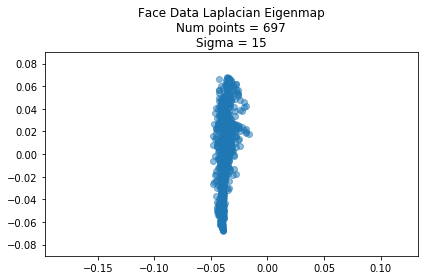

0.029739585834082625


In [297]:
plt.figure()
plt.scatter(face_embedding_lap[:,0], face_embedding_lap[:,1], alpha=0.5)
title = "Face Data Laplacian Eigenmap\nNum points = {}\nSigma = {}".format(face_embedding_lle.shape[0], sigma)
plt.title(title)
plt.tight_layout()
plt.axis('equal')
#plt.savefig("fig/{}.png".format(title.replace("\n", "_").replace(" ", "_")), dpi = 400)
plt.show()
print(loss(face_embedding_lap, X))

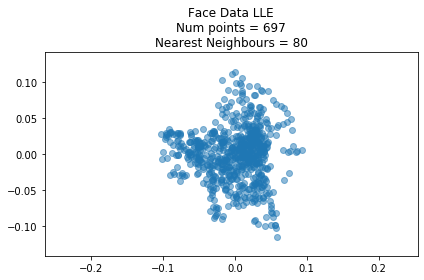

In [245]:
plt.figure()
plt.scatter(face_embedding_lle[:,0], face_embedding_lle[:,1], alpha=0.5)
title = "Face Data LLE\nNum points = {}\nNearest Neighbours = {}".format(face_embedding_lle.shape[0], n_neigh)
plt.title(title)
plt.tight_layout()
plt.axis('equal')
plt.savefig("fig/{}.png".format(title.replace("\n", "_").replace(" ", "_")), dpi = 400)
plt.show()

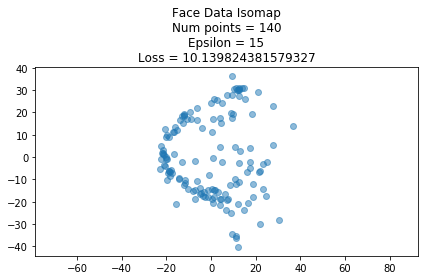

In [176]:
plt.figure()
plt.scatter(face_embedding_iso[:,0], face_embedding_iso[:,1], alpha=0.5)
title = "Face Data Isomap\nNum points = {}\nEpsilon = {}\nLoss = {}".format(face_embedding_iso.shape[0], epsilon, loss(face_embedding_iso, X) * 100)
plt.title(title)
plt.tight_layout()
plt.axis('equal')
plt.savefig("fig/{}.png".format(title.replace("\n", "_").replace(" ", "_")), dpi = 400)
plt.show()


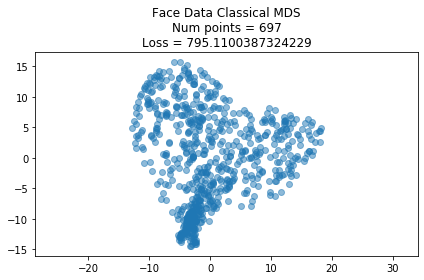

In [205]:
plt.figure()
plt.scatter(face_embedding_mds[:,0], face_embedding_mds[:,1], alpha=0.5)
title = "Face Data Classical MDS\nNum points = {}\nLoss = {}".format(face_embedding_mds.shape[0], loss(face_embedding_mds, X) * 100)
plt.title(title)
plt.tight_layout()
plt.axis('equal')
#plt.savefig("fig/{}.png".format(title.replace("\n", "_").replace(" ", "_")), dpi = 400)
plt.show()


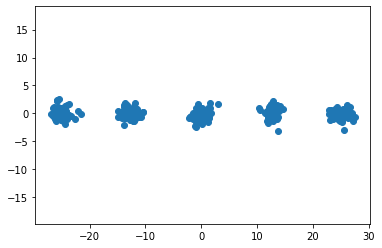

In [64]:
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.axis('equal')
plt.show()

In [213]:
np.random.seed(1600)
# X = gaussians(5, 50, 250)
X = np.array([
    (0,0,0),
    (1,1,0),
    (2,2,0),
    (3,3,0),
    (4,2,0),
#     (5,1,0),
#     (6,0,0),
#     (1,0,0),
#     (0,1,0),
#     (-1,0,0),
#     (0,-1,0),
#     (0.5,0.5,0)
])

# embedding= mds(get_pairwise_distances(X), 2)
embedding = isomap(X, 2, 25)
# embedding = lle(X,5,2)

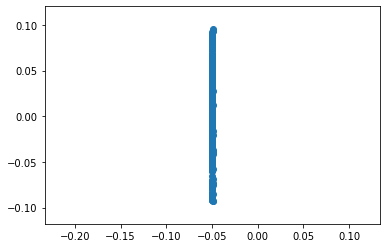

In [265]:
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1])
plt.axis('equal')
plt.show()

In [214]:
embedding

array([[ 0.20364995, -2.55314056],
       [-0.06378847, -1.16444452],
       [-0.33122689,  0.22425152],
       [-0.59866531,  1.61294756],
       [ 0.79003073,  1.88038598]])

In [215]:
X

array([[0, 0, 0],
       [1, 1, 0],
       [2, 2, 0],
       [3, 3, 0],
       [4, 2, 0]])